In [12]:
# import modules
import skvideo.io
import numpy as np

In [13]:
# get matplotlib configuration
%run plot_conf.py
plt_style()

In [14]:
# define video file name
video_file_name = 'data/data_set/car/20160706_180451.mp4'

# create an iterator over the video frames
frame_iterator = skvideo.io.vreader(video_file_name)

# load the whole video
video_data = skvideo.io.vread(video_file_name)

# print video_data shape
print('The video_data has shape:', video_data.shape)

The video_data has shape: (363, 720, 1280, 3)


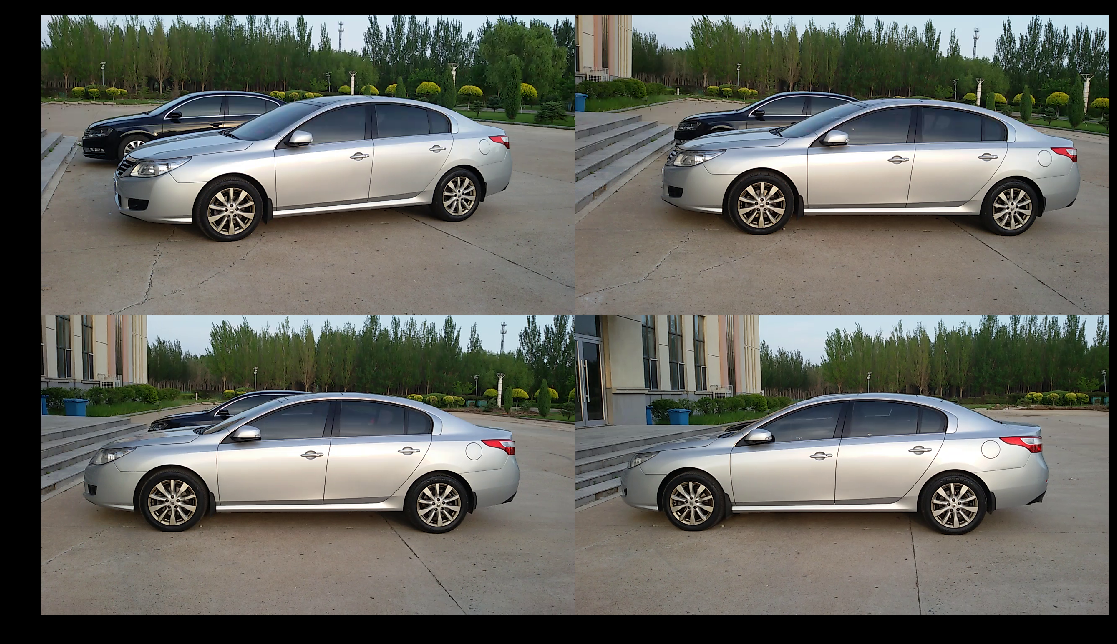

In [15]:
# display N frames: 1st, ..., ..., last
def showSamples(data, N=4, height=12):
    rows = np.floor(N ** 0.5)
    columns = N / rows
    for p in range(0, N):
        plt.subplot(rows, columns, p + 1)
        idx = p * (data.shape[0] - 1) // (N - 1) if N > 1 else 0
        plt.imshow(data[idx])
        plt.axis('off')
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
    s = data.shape
    plt.gcf().set_size_inches((height*s[2]/s[1]/rows, height/columns))
    
showSamples(video_data)

In [16]:
import os

# get classes
classes_file_name = 'synset_words.txt'
if not os.access(classes_file_name, os.W_OK):
    synset_URL = 'https://github.com/szagoruyko/functional-zoo/raw/master/synset_words.txt'
    os.system('wget ' + synset_URL)

classes = list()
with open(classes_file_name) as f:
    for line in f:
        classes.append(line.strip().split(' ', 1)[1].split(', ')[0])
classes = tuple(classes)

In [17]:
# print first 5 classes and indeces
for i in range(0, 5):
    print(i, classes[i])

0 tench
1 goldfish
2 great white shark
3 tiger shark
4 hammerhead


In [18]:
from torchvision import transforms as trn

# define image transformation
pre_proc = trn.Compose([
        trn.ToPILImage(),
        trn.Scale(256),
        trn.CenterCrop(224),
        trn.ToTensor(),
        trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [19]:
from torchvision import models

# get network
resnet_18 = models.resnet18(pretrained=True)
resnet_18.eval();

In [20]:
from torch.autograd import Variable as V
from torch.nn.functional import softmax

# forward first frame
x = V(pre_proc(video_data[0]).unsqueeze(0), volatile=True)
logit = resnet_18(x)
h_x = softmax(logit).data.squeeze()

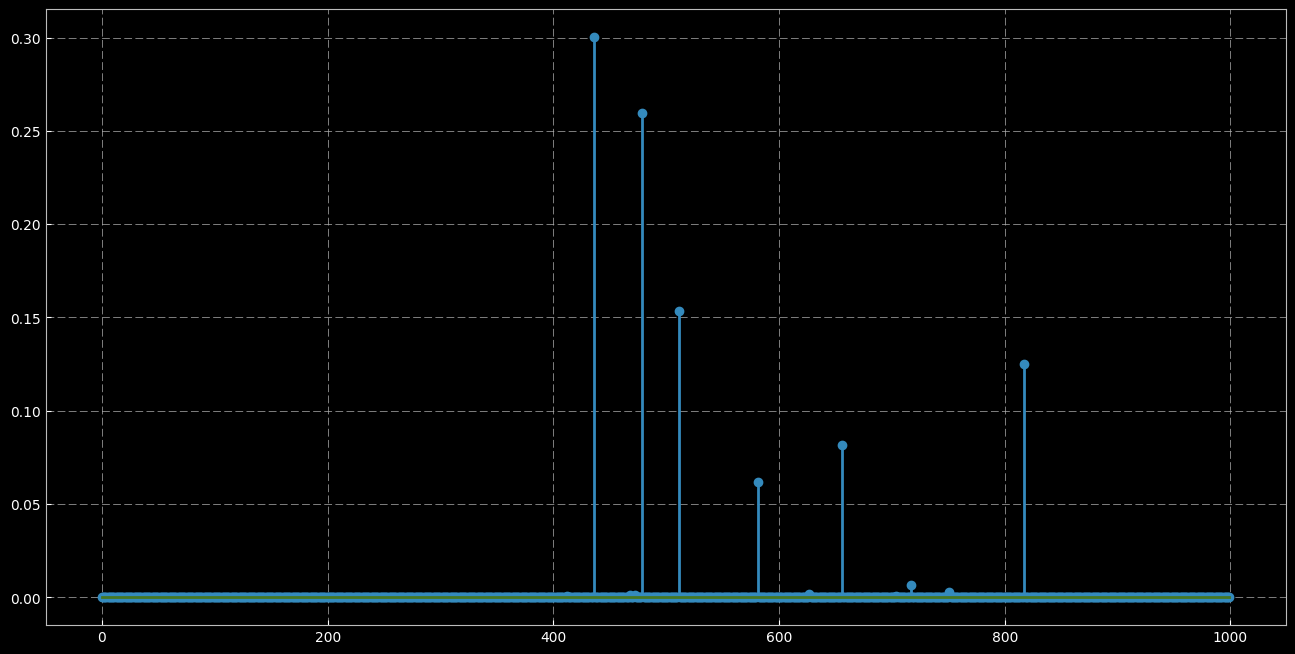

In [21]:
# probability dist. of first frame
plt.stem(np.arange(len(h_x)), h_x.numpy())
plt.grid('on')

In [22]:
# print names of 6 most likely predictions and returns their indeces
def disp_top_n_classes(p, N=5):
    probs, idx = p.sort(0, True)
    for i in range(0, N):
        print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))
    return idx[:N]
disp_top_n_classes(h_x, 6);

0.300 -> beach wagon
0.259 -> car wheel
0.154 -> convertible
0.125 -> sports car
0.081 -> minivan
0.062 -> grille


In [23]:
import torch
from ipywidgets import FloatProgress
from IPython.display import display

# compute probabilities for all frames
frames_nb = video_data.shape[0]
prg_bar = FloatProgress(min=0, max=frames_nb); display(prg_bar)
prob_mat = torch.Tensor(frames_nb, len(classes))
my_embedding = torch.zeros(frames_nb, 512)
def fun(m, i, o):
    if not hasattr(fun, 'i'): fun.i = 0
    my_embedding[fun.i].copy_(o.data)
    fun.i += 1
avgpool_layer = resnet_18._modules.get('avgpool')
h = avgpool_layer.register_forward_hook(fun)
for idx in range(0, frames_nb):
    x = V(pre_proc(video_data[idx]).unsqueeze(0), volatile=True)
    logit = resnet_18(x)
    h_x = softmax(logit).data.squeeze()
    prob_mat[idx].copy_(h_x)
    prg_bar.value += 1
h.remove()

0.472 -> beach wagon
0.213 -> minivan
0.110 -> car wheel
0.085 -> convertible
0.049 -> grille


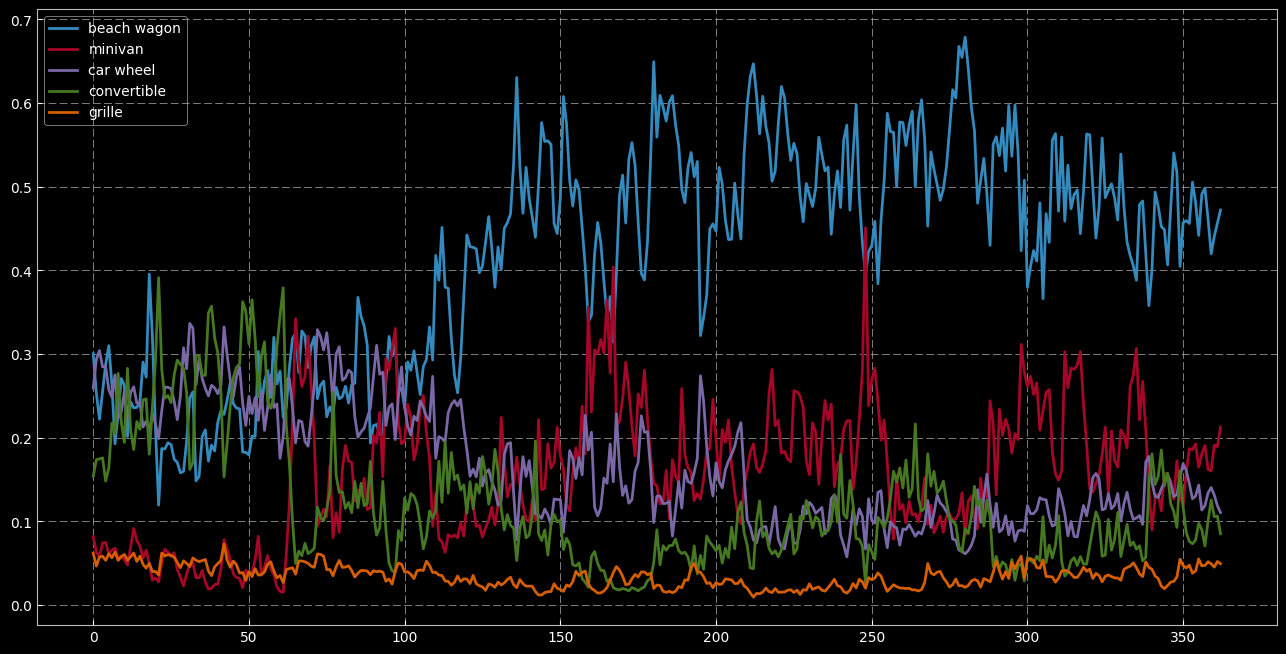

In [24]:
# get best N average classes
nb_classes = 5
video_mean_prob = prob_mat.mean(dim=0).squeeze()
top_n_ind = disp_top_n_classes(h_x, 5)
top_n_classes = prob_mat.index_select(1, top_n_ind)
# and plot them
plt.plot(top_n_classes.numpy())
plt.legend([classes[idx] for idx in top_n_ind], loc='upper left');

In [25]:
%%HTML

<video width="320" controls>
    <source src="data/data_set/car/20160706_180451.mp4" type="video/mp4">
</video>

In [ ]:
# from network_bisection notebook, emb_size: 512

# uncomment to display the network graph
# from utils.visualise import make_dot
# make_dot(h_x)

# uncomment to print and inspect the network object
# print(resnet_18)

In [26]:
my_embedding_np = my_embedding.numpy()
my_embedding


 2.1150  1.1737  1.3397  ...   0.4077  0.5142  0.1489
 2.0797  1.2637  1.3622  ...   0.3527  0.5766  0.1074
 2.0881  1.1985  1.3195  ...   0.3286  0.5493  0.1345
          ...             ⋱             ...          
 1.6044  1.7229  1.9035  ...   0.4605  0.4617  0.0612
 1.6016  1.6165  1.9135  ...   0.4669  0.4345  0.0631
 1.5676  1.5470  1.7480  ...   0.3898  0.4406  0.0555
[torch.FloatTensor of size 363x512]

In [27]:
# my current embedding collection is 363 x 512
# there are 363 samples and 512 features
# the covariance matrix is therefore singular...

# from matplotlib.mlab import PCA

# pca = PCA(my_embedding_np)

In [28]:
# video-bubble centre
centre = my_embedding.mean(0)

# video-bubble std
radius = my_embedding.std(0).squeeze().norm()

In [29]:
print('The current video-bubble radius is %.2f' % radius)

The current video-bubble radius is 4.67
